In [ ]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# prob 2 part a
# find the correspondenses between two point clouds with a given rigid transformations
# X is the first point cloud, Y is the second
#trans is the give nrigid transformation
# rot is the rotation
# max_dist is the maximum distance for filtering points
def find_correspondences(X, Y, trans, rot, max_dis):
    # store correspondenses here
    cor = []
    # library function allow for efficient nearest-neighbor searching
    tree = cKDTree(Y)  
    # transforms the coordinate system of the first set of points to the second set of points
    transformed_X = (rot @ X.T).T + trans

    # loop throug hthe points
    for i, x in enumerate(transformed_X):
        # finds the closest point to the current transformed point from x
        dis, j = tree.query(x)
        # adds the point if the distance is below the threshold
        if dis < max_dis:
            cor.append((i, j))

    return cor


In [ ]:
# prob 2 part b
# calculates the optimal rigid transformation that will align the points based on correspondenses
# X is the first point cloud, Y is the second
def rigid_registration(X, Y, cor):
    num_cor = len(cor)

    # points in the point clouds
    X_p = np.array([X[i] for i, _ in cor])
    Y_p = np.array([Y[j] for _, j in cor])
    # centroids
    X_centroid = np.mean(X_p, axis=0)
    Y_centroid = np.mean(Y_p, axis=0)
    # center the point clouds
    X_centered = X_p - X_centroid
    Y_centered = Y_p - Y_centroid

    # cross covariance
    cross_co = (Y_centered.T @ X_centered) / num_cor
    # SVD on the cross covariance matrix
    U, S, Vt = np.linalg.svd(cross_co)

    # optimal rotation
    rotation = U @ np.diag([1, 1, np.linalg.det(U @ Vt)]) @ Vt
    # optimal translation
    translation = Y_centroid - rotation @ X_centroid

    return translation, rotation


optimal t:
 [-0.01959777  0.09897703  0.00434   ]
optimal R:
 [[ 0.99739837  0.0648734   0.03143142]
 [-0.06427833  0.99773975 -0.01958777]
 [-0.0326311   0.01751645  0.99931396]]
RMSE:
 0.14034831762286326


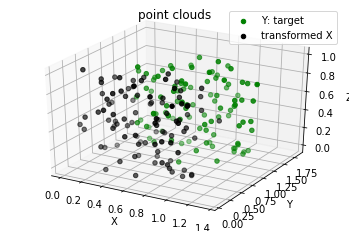

In [ ]:
# part c & d
# aligns two sets of point clouds using the iterative closest point
# X is the first point cloud, Y is the second
# t0 is the initial translation
# R0 is the initilal rotations
# dmax is the max distance for filtering later
# iters the number of iterations
def ICP(X, Y, t0, R0, dmax, iters):    
    for _ in range(iters):
        # correspondenses
        cor = find_correspondences(X, Y, t0, R0, dmax)
        # compute registration
        t, R = rigid_registration(X, Y, cor)

    return t, R, cor

# rmse func
# X is the first point cloud
# Y is the second
# C i the 
def calculate_rmse(X, Y, cor, t, r):
    errors = []
    for i, j in cor:
        # transformation of current point in X
        transformed_point = r @ X[i] + t  

        # error between the transformed point and the Y point
        error = np.linalg.norm(Y[j] - transformed_point)**2  
        errors.append(error)

    rmse = np.sqrt(np.mean(errors))  
    return rmse

t0 = np.zeros(3)
R0 = np.eye(3)
dmax = 0.25
iters = 30
# to see this code working, we create an initial set of points
X = np.random.rand(100, 3)
Y = np.dot(X, np.array([[0.866, -0.5, 0], [0.5, 0.866, 0], [0, 0, 1]]).T) + np.array([0.5, 0.5, 0])
# run the icp algorithm
t_o, R_o, cor_o = ICP(X, Y, t0, R0, dmax, iters)


# call RSEM function
rmse = calculate_rmse(X, Y, cor_o, t_o, R_o)

print("optimal t:\n", t_o)
print("optimal R:\n", R_o)
print("RMSE:\n", rmse)
# transformed X for plotting the points
trans_X = np.dot(X, R_o.T) + t_o
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c='g', label="Y: target")
ax.scatter(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], c='black', label="transformed X")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title("point clouds")
plt.show()

optimal t:
 [0.08844609 0.01414317 0.07167098]
optimal R:
 [[ 0.99439196  0.07890639  0.07041592]
 [-0.0802859   0.99662731  0.01697608]
 [-0.0688389  -0.02253428  0.99737326]]
RMSE:
 0.10210937939894171


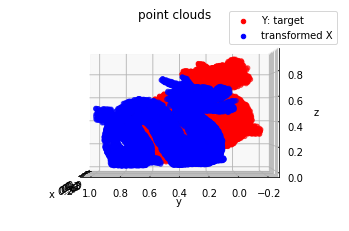

In [ ]:
# part d
X = np.loadtxt('pclX.txt')
Y = np.loadtxt('pclY.txt')

# params for ICP
t0 = np.zeros(3)
R0 = np.eye(3)
dmax = 0.25
num_iters = 30
# ICP function run with the initial given paramters
t_opt, r_opt, cor_opt = ICP(X, Y, t0, R0, dmax, num_iters)


rmse = calculate_rmse(X, Y, cor_opt, t_opt, R_opt)

print("optimal t:\n", t_opt)
print("optimal R:\n", R_opt)
print("RMSE:\n", rmse)
# x transformation for plotting
transformed_X = np.dot(X, R_opt.T) + t_opt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c='r', label="Y: target")
ax.scatter(transformed_X[:, 0], transformed_X[:, 1], transformed_X[:, 2], c='b', label="transformed X")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.title("point clouds")

# for changing pov
ax.view_init(elev=0, azim=180)

plt.show()
